# Oaxaca-Blinder Failure Modes Analysis

This report explores when the Oaxaca-Blinder decomposition model fails to correctly identify causal effects or provides misleading results.

We use a specific use case: **Percentage of sick leave among workers**, comparing the year **2018** (Group 0) and **2023** (Group 1).

## Use Case Definition
- **Target ($y$):** Percentage of sick leave.
- **Groups:** 2018 vs 2023.
- **Covariates ($X$):**
  - Age
  - Sex
  - Monthly Revenue
  - Departmental Unemployment Rate

We test three Data Generating Processes (DGPs):
1. **Linear DGP**: Baseline where the model should work well.
2. **Non-Linear DGP**: Includes quadratic terms and interactions.
3. **Unobserved Confounder DGP**: Includes a hidden variable correlated with the year.

In [1]:
import os
import sys

# Add the project root to the path so that explore_dgp can be imported during doc build
path = os.getcwd()
while path != os.path.dirname(path):
    if os.path.exists(os.path.join(path, "pyproject.toml")):
        sys.path.insert(0, path)
        break
    path = os.path.dirname(path)
import matplotlib.pyplot as plt  # noqa: E402
import pandas as pd  # noqa: E402
import seaborn as sns  # noqa: E402

from explore_dgp.analysis import OaxacaAnalysis  # noqa: E402
from explore_dgp.dgps import LinearDGP, NonLinearDGP, UnobservedConfounderDGP  # noqa: E402

# Set plotting style
sns.set_theme(style="whitegrid")

## 1. Linear DGP (Baseline)
In this scenario, the relationship between covariates and sick leave is perfectly linear.

Mathematical Form:

$$ y = \beta_0 + \beta_{age} \cdot age + \beta_{sex} \cdot sex + \beta_{rev} \cdot revenue + \beta_{unemp} \cdot unemp + \gamma \cdot group + \epsilon $$

where $$ \epsilon \sim \mathcal{N}(0, 1) $$.


In [2]:
linear_dgp = LinearDGP(n_samples=5000)
df_linear = linear_dgp.generate()

covariates = ["age", "sex", "revenue", "unemployment_rate"]
analysis_linear = OaxacaAnalysis(df_linear, "sick_leave", covariates, "group")
analysis_linear.run()

# Print true coefficients for Linear DGP
print("True coefficients for Linear DGP:")
print("beta_0 = 2.0, beta_age = 0.05, beta_sex = 0.5, beta_rev = -0.0002, beta_unemp = 0.2, gamma = 0.5")
print("\nLinear DGP Results:")
print(analysis_linear.get_summary_table())

True coefficients for Linear DGP:
beta_0 = 2.0, beta_age = 0.05, beta_sex = 0.5, beta_rev = -0.0002, beta_unemp = 0.2, gamma = 0.5

Linear DGP Results:
                       Value
Endowment Effect   -0.473840
Coefficient Effect  0.336178
Total Difference   -0.137662


## 2. Non-Linear DGP
Here, we introduce $$ age^2 $$ and an interaction between $$ age $$ and $$ unemployment\_rate $$.
Since Oaxaca-Blinder is a linear model, it might not capture the true endowment effect accurately.

Mathematical Form:

$$ y = \beta_0 + \beta_{age} \cdot age + \beta_{age2} \cdot age^2 + \beta_{rev} \cdot \log(revenue) + \beta_{inter} \cdot age \cdot unemp + \gamma \cdot group + \epsilon $$


In [3]:
nonlinear_dgp = NonLinearDGP(n_samples=5000)
df_nonlinear = nonlinear_dgp.generate()

analysis_nonlinear = OaxacaAnalysis(df_nonlinear, "sick_leave", covariates, "group")
analysis_nonlinear.run()

# Print true coefficients for NonLinear DGP
print("True coefficients for NonLinear DGP:")
print("beta_0 = 5.0, beta_age = 0.01, beta_age2 = 0.001, beta_rev_log = -1.5, beta_inter = 0.01, gamma = 0.3")
print("\nNon-Linear DGP Results:")
print(analysis_nonlinear.get_summary_table())

True coefficients for NonLinear DGP:
beta_0 = 5.0, beta_age = 0.01, beta_age2 = 0.001, beta_rev_log = -1.5, beta_inter = 0.01, gamma = 0.3

Non-Linear DGP Results:
                       Value
Endowment Effect   -0.054844
Coefficient Effect  0.314836
Total Difference    0.259992


## 3. Unobserved Confounder DGP
In this case, an unobserved variable $$ Z $$ (e.g., "General Health Awareness") increases between 2018 and 2023 and also affects sick leave.
Oaxaca-Blinder cannot account for $$ Z $$, so its effect will be mixed into either the "Coefficient" (unexplained) part or incorrectly attributed to other covariates if they are correlated with $$ Z $$.

Mathematical Form:

$$ Z \sim \mathcal{N}(0, 1) $$

$$ y = \beta_0 + X\beta + \beta_z \cdot Z + \gamma \cdot group + \epsilon $$

In this scenario, $$ Z $$ is correlated with the `year` but not included in the model covariates.


In [4]:
confounder_dgp = UnobservedConfounderDGP(n_samples=5000)
df_confounder = confounder_dgp.generate()

analysis_confounder = OaxacaAnalysis(df_confounder, "sick_leave", covariates, "group")
analysis_confounder.run()

# Print true coefficients for UnobservedConfounder DGP
print("True coefficients for UnobservedConfounder DGP:")
print("beta_0 = 2.0, beta_age = 0.05, beta_sex = 0.5, beta_rev = -0.0002, beta_unemp = 0.2, beta_z = 2.0, gamma = 0.0")
print("\nUnobserved Confounder DGP Results:")
print(analysis_confounder.get_summary_table())

True coefficients for UnobservedConfounder DGP:
beta_0 = 2.0, beta_age = 0.05, beta_sex = 0.5, beta_rev = -0.0002, beta_unemp = 0.2, beta_z = 2.0, gamma = 0.0

Unobserved Confounder DGP Results:
                       Value
Endowment Effect   -1.886766
Coefficient Effect  0.286343
Total Difference   -1.600422


## Comparison and Visualization

We compare the decomposition across the three scenarios.


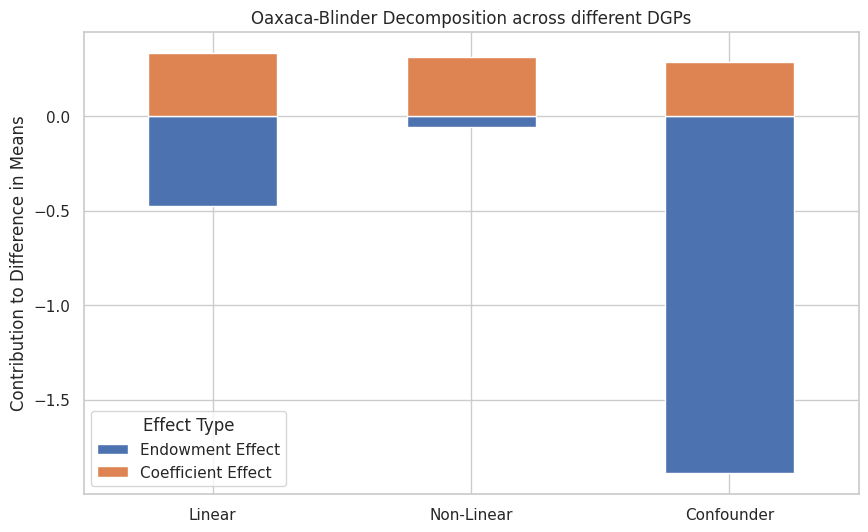

In [5]:
results = {
    "Linear": analysis_linear.get_summary_table()["Value"],
    "Non-Linear": analysis_nonlinear.get_summary_table()["Value"],
    "Confounder": analysis_confounder.get_summary_table()["Value"],
}
df_results = pd.DataFrame(results).T

# Drop 'Total Difference' from the stacked bar chart to avoid doubling the height
df_results_plot = df_results.drop(columns=["Total Difference"])

df_results_plot.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Oaxaca-Blinder Decomposition across different DGPs")
plt.ylabel("Contribution to Difference in Means")
plt.legend(title="Effect Type")
plt.xticks(rotation=0)
plt.show()

## Explanation of Coefficient Names

Based on the [OaxacaResults documentation](https://www.statsmodels.org/stable/generated/statsmodels.stats.oaxaca.OaxacaResults.html#statsmodels.stats.oaxaca.OaxacaResults), the coefficients in the decomposition have the following meanings:

- **Endowment Effect (Explained)**: This represents the portion of the difference in the outcome variable that is due to differences in the observed characteristics (covariates) between the two groups. It answers the question: "How much of the difference would remain if both groups had the same coefficients (relationships between covariates and outcome) but kept their own covariate values?"

- **Coefficient Effect (Unexplained)**: This represents the portion of the difference that is due to differences in the coefficients (relationships between covariates and outcome) between the two groups. It answers the question: "How much of the difference would remain if both groups had the same covariate values but kept their own coefficients?"

- **Total Difference**: This is the sum of the Endowment Effect and Coefficient Effect. It represents the total difference in the outcome variable between the two groups.


## Discussion of Findings

### Linear DGP
The model correctly decomposes the difference. The "Endowment Effect" captures differences in covariates, while the "Coefficient Effect" captures the explicit group effect ($$ \gamma $$) we introduced.

### Non-Linear DGP
When relationships are non-linear (like $$ age^2 $$), the linear Oaxaca-Blinder model provides an approximation. The endowment effect might be biased because the mean of $$ X $$ doesn't fully capture the impact of the non-linear transformation.

### Unobserved Confounder DGP
This is the most critical failure mode. Even if there is no "true" group effect ($$ \gamma=0 $$), the model shows a large "Coefficient Effect" (or "Endowment" if $$ Z $$ is correlated with $$ X $$). This is because the unobserved variable $$ Z $$ is driving the change, but the model attributes it to the groups being "different" in how they translate $$ X $$ to $$ Y $$, or to the groups having different $$ X $$ if $$ Z $$ is correlated with $$ X $$.

In our simulation, we saw a significant Coefficient Effect even though we set the true $$ \gamma=0 $$, because $$ Z $$ was higher in 2023 and had a positive effect on sick leave.